#### Preamble

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

from keras import backend as K
from keras.layers import (Input, Activation, Dense, Lambda, Layer, 
                          add, multiply)
from keras.models import Model, Sequential
from keras.callbacks import TerminateOnNaN
from keras.datasets import mnist

from tqdm import tnrange

import tensorflow as tf

Using TensorFlow backend.


#### Notebook Environment 

In [3]:
plt.style.use('seaborn-notebook')
sns.set_context('notebook')
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [4]:
'TensorFlow version: ' + K.tf.__version__

'TensorFlow version: 1.4.0'

In [5]:
sess = tf.InteractiveSession()

### Example: Diagonal Gaussians

In [6]:
D = 2
q_mu = np.float32([ 1., 4.])
p_mu = np.float32([-3., 2.])
q_sigma = np.ones(D).astype('float32')
p_sigma = 2.5*np.ones(D).astype('float32')

In [7]:
q = tf.distributions.Normal(loc=q_mu, scale=q_sigma)
p = tf.distributions.Normal(loc=p_mu, scale=p_sigma)

<IPython.core.display.Javascript object>


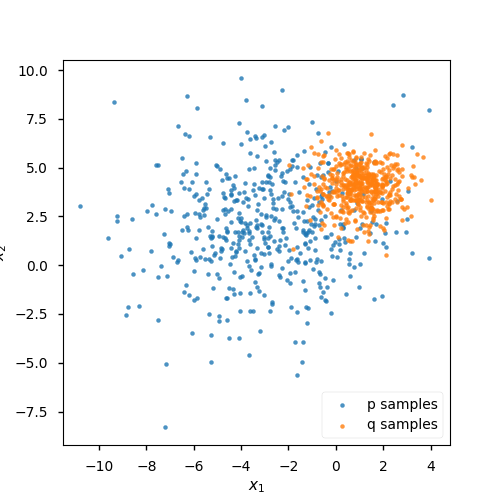

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(*p.sample(sample_shape=(500,)).eval().T, 
           s=8., alpha=.8, label='p samples')

ax.scatter(*q.sample(sample_shape=(500,)).eval().T, 
           s=8.,alpha=.8, label='q samples')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax.legend()

plt.show()

### Closed-form KL divergence between diagonal Gaussians

In [9]:
def kl_divergence_gaussians(q_mu, q_sigma, p_mu, p_sigma):
    
    r = q_mu - p_mu
   
    return np.sum(np.log(p_sigma) - np.log(q_sigma)
                  - .5 * (1. - (q_sigma**2 + r**2) / p_sigma**2), 
                  axis=-1)

In [10]:
kl_true = kl_divergence_gaussians(q_mu, q_sigma, p_mu, p_sigma)
kl_true

2.5925815

In [11]:
tf.reduce_sum(tf.distributions.kl_divergence(
    tf.distributions.Normal(loc=q_mu, scale=q_sigma),
    tf.distributions.Normal(loc=p_mu, scale=p_sigma)), axis=-1).eval()

2.5925813

### Monte Carlo estimation

The KL divergence is an expectation of log density ratios over distribution p. We can approximate it with Monte Carlo samples.

In [12]:
mc_samples = 10000

In [13]:
def log_density_ratio_gaussians(z, q_mu, q_sigma, p_mu, p_sigma):
 
    r_p = (z - p_mu) / p_sigma
    r_q = (z - q_mu) / q_sigma
    
    return np.sum(np.log(p_sigma) - np.log(q_sigma) + 
                  .5 * (r_p**2 - r_q**2), axis=-1)

In [14]:
mc_estimates = pd.Series(
    log_density_ratio_gaussians(
        q.sample(sample_shape=(mc_samples,)).eval(), 
        q_mu, q_sigma, 
        p_mu, p_sigma
    )
)

In [15]:
# cumulative mean of the MC estimates
mean = mc_estimates.expanding().mean()

In [16]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

<IPython.core.display.Javascript object>


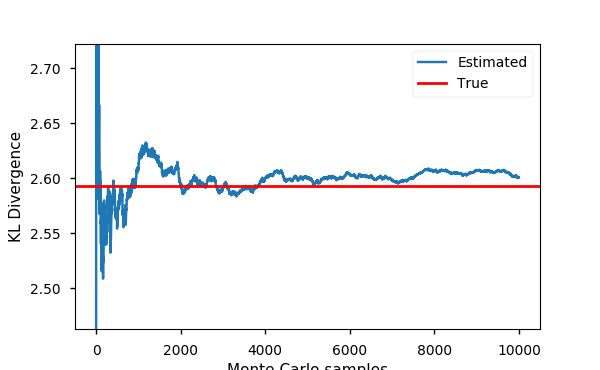

In [17]:
fig, ax = plt.subplots(figsize=golden_size(6))

mean.plot(ax=ax, label='Estimated')

ax.axhline(y=kl_true, color='r', linewidth=2., label='True')

ax.set_xlabel('Monte Carlo samples')
ax.set_ylabel('KL Divergence')

ax.set_ylim(.95*kl_true, 1.05*kl_true)

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


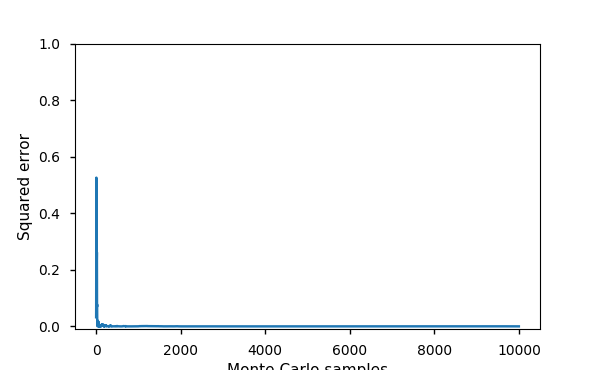

In [18]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.plot(np.square(mean - kl_true))

ax.set_xlabel('Monte Carlo samples')
ax.set_ylabel('Squared error')

ax.set_ylim(-0.01, 1.)

plt.show()

In [19]:
mean.index.name = 'samples'
mean_df = pd.DataFrame(mean.rename('mc_estimate'))

<IPython.core.display.Javascript object>


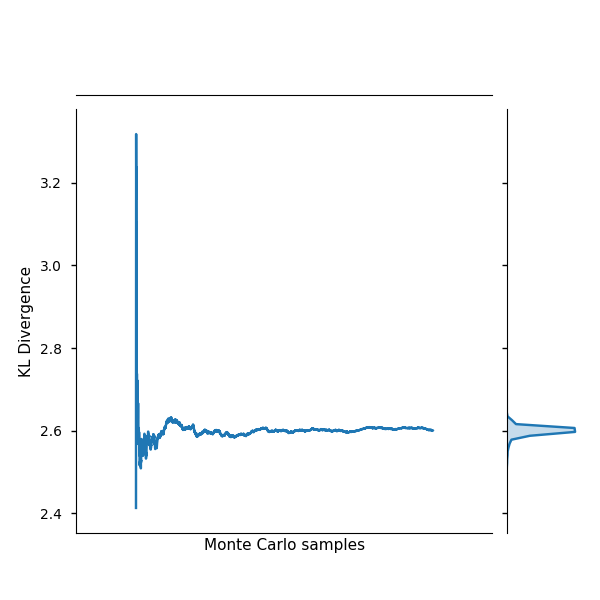

In [20]:
g = sns.JointGrid(x='samples', y='mc_estimate', 
                  data=mean_df.reset_index())

g = g.plot_joint(plt.plot)
g = g.plot_marginals(sns.kdeplot, shade=True)

g.ax_marg_x.clear()
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_yticks([])

g.set_axis_labels('Monte Carlo samples', 'KL Divergence')